In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import keras
import tensorflow as tf





test_dir = '/content/drive/MyDrive/KASHIF DEEP LEARNING/transfer learning/ Jason Brownlee/dataBase/test'

validation_dir = '/content/drive/MyDrive/KASHIF DEEP LEARNING/transfer learning/ Jason Brownlee/dataBase/val'

train_dir = '/content/drive/MyDrive/KASHIF DEEP LEARNING/transfer learning/ Jason Brownlee/dataBase/train'

In [9]:
image_size=[263,173]


datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = datagen.flow_from_directory(train_dir, class_mode='categorical', batch_size=32,target_size=image_size)
valid_generator = datagen.flow_from_directory(validation_dir, class_mode='categorical', batch_size=32,target_size=image_size)
test_generator = datagen.flow_from_directory(test_dir, class_mode='categorical', batch_size=32,target_size=image_size)


Found 4200 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 600 images belonging to 12 classes.


In [10]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.applications.vgg16 import VGG16

image_size=[263,173]

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(263,173, 3))





In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
# add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(12, activation='softmax'))


In [13]:

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))


In [14]:


model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True) ,
              metrics=['accuracy'] ,)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path='/content/drive/MyDrive/KASHIF DEEP LEARNING/transfer learning/##GRAPH/weight_00.h5'

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [16]:
history  = model.fit(


                     train_generator,
                     batch_size=32,
                     epochs=5,
                     verbose='auto',
                     callbacks=callbacks_list,
                     validation_split=0.0, 
                     validation_data=valid_generator,
                     shuffle=True,
                     class_weight=None,
                     sample_weight=None,
                     initial_epoch=0,
                     steps_per_epoch=4200/32,
                     validation_steps=1200/32,
                     validation_batch_size=None,
                     validation_freq=1,
                     max_queue_size=10,
                     workers=1,
                     use_multiprocessing=False)

Epoch 1/5
132/131 [==============================] - ETA: -8s - loss: 23.3584 - accuracy: 0.4812
Epoch 00001: val_loss improved from inf to 0.37734, saving model to /content/drive/MyDrive/KASHIF DEEP LEARNING/transfer learning/##GRAPH/weight_00.h5
131/131 [==============================] - 1974s 15s/step - loss: 23.3584 - accuracy: 0.4812 - val_loss: 0.3773 - val_accuracy: 0.9033 - lr: 0.0100
Epoch 2/5
132/131 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.8762
Epoch 00002: val_loss improved from 0.37734 to 0.30109, saving model to /content/drive/MyDrive/KASHIF DEEP LEARNING/transfer learning/##GRAPH/weight_00.h5
131/131 [==============================] - 40s 301ms/step - loss: 0.5338 - accuracy: 0.8762 - val_loss: 0.3011 - val_accuracy: 0.9058 - lr: 0.0100
Epoch 3/5
132/131 [==============================] - ETA: 0s - loss: 0.2907 - accuracy: 0.9202
Epoch 00003: val_loss did not improve from 0.30109
131/131 [==============================] - 39s 295ms/step - l

In [17]:
model.save('/content/drive/MyDrive/KASHIF DEEP LEARNING/transfer learning/##GRAPH/model_00.h5')

In [18]:

vgg16_saved = keras.models.load_model('/content/drive/MyDrive/KASHIF DEEP LEARNING/transfer learning/##GRAPH/model_00.h5')


In [19]:
vgg16_saved.evaluate(test_generator)

19/19 [==============================] - 211s 12s/step - loss: 0.6606 - accuracy: 0.8617


[0.6605921983718872, 0.8616666793823242]

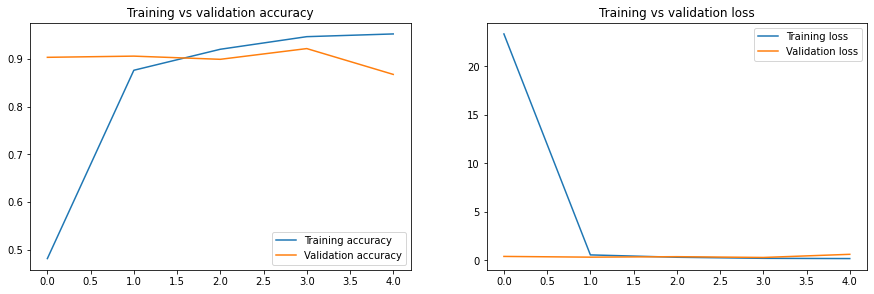

In [20]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.show()

In [22]:
ledom = vgg16_saved
test = test_generator

In [23]:
y_pred = ledom.predict(test)
y_pred = np.argmax(y_pred,axis=1)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test.labels,y_pred))

              precision    recall  f1-score   support

           0       0.17      0.16      0.16        50
           1       0.09      0.08      0.08        50
           2       0.17      0.06      0.09        50
           3       0.12      0.10      0.11        50
           4       0.10      0.08      0.09        50
           5       0.08      0.10      0.09        50
           6       0.06      0.06      0.06        50
           7       0.08      0.08      0.08        50
           8       0.08      0.08      0.08        50
           9       0.02      0.02      0.02        50
          10       0.12      0.10      0.11        50
          11       0.08      0.18      0.11        50

    accuracy                           0.09       600
   macro avg       0.10      0.09      0.09       600
weighted avg       0.10      0.09      0.09       600



In [25]:
import pandas as pd
classes=[i for i in range(12)]
con_mat_df = pd.DataFrame(confusion_matrix(test.labels,y_pred),
                     index = classes, 
                     columns = classes)

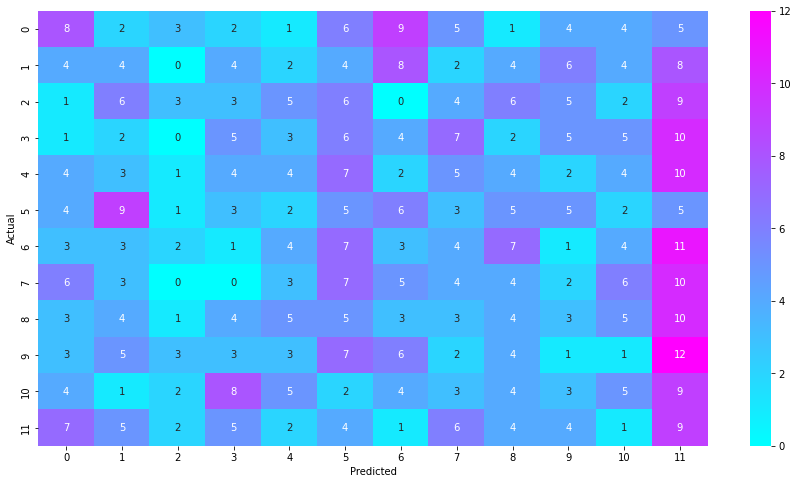

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(15, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()